In [1]:
# Mounting dataset from Google Drive:
from google.colab import drive
drive.mount('/content/drive')
# Libraries for data storage and image processing
import numpy as np
import pandas as pd
import os, re
from PIL import Image, ImageEnhance

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
!pip install keras # not currently imported apparently
from keras.layers import Dense, Input
from keras.models import Sequential
from keras import metrics, models, layers
from keras.preprocessing import image
# TODO: figure out layers and method of training
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Libraries
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we read in the data from the local directory where it is stored, and process the images.

In [2]:
# We will define the paths to our files
# Current directory structure: train has subdirectories A-Z, each with images stored inside,
# test just has the files with the letter, label is in file name.
# train_images = '../dataset/asl_alphabet_train/asl_alphabet_train'
# test_images = '../dataset/asl_alphabet_test/asl_alphabet_test'
train_images = '/content/drive/My Drive/dataset/asl_alphabet_train/asl_alphabet_train'
test_images = '/content/drive/My Drive/dataset/asl_alphabet_test/asl_alphabet_test'


# Load Data #

Read in the data from the local directory and store it in a pandas DataFrame. We will display the first 5 rows with df.head() to validate our result.

In [3]:
train_data = pd.DataFrame()
categories = []
data = []

for subdir, dirs, files in os.walk(train_images, topdown=True):
    directory_name = os.path.basename(subdir)
    # Don't include the directory we are currently in, trying to get letter categories.
    if(directory_name != 'asl_alphabet_train'):
        # categories.append(os.path.basename(subdir).split("\\")[0])
        categories.append(directory_name)
    directory_data = []
    for file in files:
        directory_data.append(file)

    data.append(directory_data)

data = [directory for directory in data if directory] # Remove null elements
df = pd.DataFrame(data, categories)

print(df)

                    0                1                2                3     \
I              I1976.jpg        I2359.jpg        I2679.jpg        I2911.jpg   
D               D260.jpg        D2776.jpg        D2786.jpg        D2720.jpg   
G               G495.jpg          G54.jpg         G332.jpg        G2704.jpg   
H               H429.jpg         H455.jpg        H2389.jpg         H391.jpg   
A              A2716.jpg        A2629.jpg        A2627.jpg        A2678.jpg   
B              B2783.jpg         B363.jpg        B2865.jpg         B355.jpg   
del          del2496.jpg      del2685.jpg      del1891.jpg      del2797.jpg   
F               F298.jpg        F2432.jpg        F2167.jpg        F2615.jpg   
E              E2699.jpg        E2767.jpg         E898.jpg         E581.jpg   
C              C2709.jpg        C2954.jpg        C2887.jpg        C2956.jpg   
Q              Q2867.jpg         Q661.jpg         Q797.jpg        Q2745.jpg   
L              L2327.jpg         L193.jpg        L19

Some information about our dataset

In [4]:
print(f"Dataset shape: {df.shape}")
print(f"Dataset size: {df.size}")
print(f"Data type: {df.dtypes}")
print(f"Dataset columns: {df.columns}")

Dataset shape: (29, 3000)
Dataset size: 87000
Data type: 0       object
1       object
2       object
3       object
4       object
         ...  
2995    object
2996    object
2997    object
2998    object
2999    object
Length: 3000, dtype: object
Dataset columns: RangeIndex(start=0, stop=3000, step=1)


#### Preprocess data if necessary (i.e. drop certain columns we are not using). Since pandas DataFrames do not support images, we will read the data into a numpy array. Since the dataset is considerably large, we will use a Keras function to support batching ####

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Using 17400 files for validation.


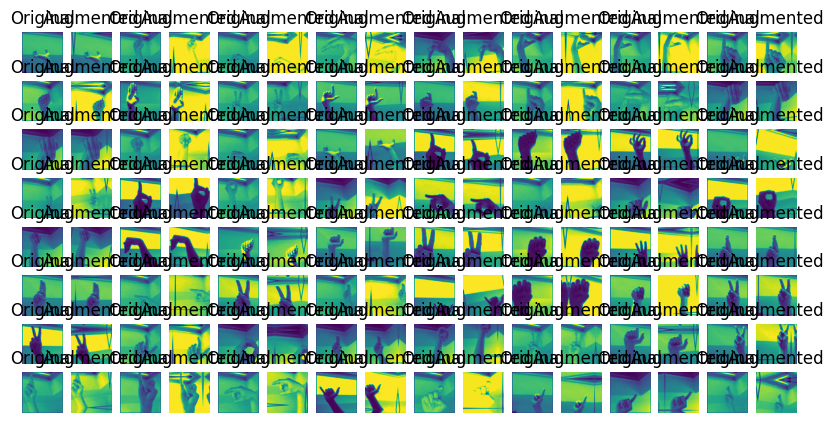

In [7]:
'''train_images_list = []
for index, row in df.iterrows():
    train_images_dir = f"{train_images}/{index}"
    check = True
    for value in row:
        image_path = f"{train_images_dir}/{value}"
        img = image.load_img(image_path, target_size=(200, 200))
        img = image.img_to_array(img)
        train_images_list.append(img)

training_images = np.array(train_images_list)'''
directory = train_images
training_images, validation_images = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=64,
    image_size=(128, 128),
    seed=42,
    shuffle=True,
    validation_split=0.2,
    subset='both', # we will use 20% data for validation
)

def process(image, label): # for normalizing dataset
    image = tf.cast(image/255.0, tf.float32)
    return image, label

brightness_layer = tf.keras.layers.RandomBrightness(factor=(0, 0.5)) # factor is the range for adjustment
contrast_layer = tf.keras.layers.RandomContrast(factor=0.5) # factor determines contrast adjustment range
gaussian_noise_layer = tf.keras.layers.GaussianNoise(stddev=0.35)
rotation_layer = tf.keras.layers.RandomRotation(factor=(-1/36, 1/36), fill_mode='reflect')
translation_layer = tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='reflect')

augmentation = tf.keras.Sequential([
    brightness_layer,
    contrast_layer,
    gaussian_noise_layer,
    rotation_layer,
    translation_layer
])

# Plot the images to determine how it is currently working
# Apply the augmentation layers to one batch of images
for images, _ in training_images.take(1):  # Take a single batch
    augmented_images = augmentation(images, training=True)

    # Plot the original and augmented images side by side
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        # Display original images
        ax = plt.subplot(16, 16, i * 2 + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")

        # Display augmented images
        ax = plt.subplot(16, 16, i * 2 + 2)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")

    plt.show()

training_images = training_images.map(lambda x, y: (augmentation(x, training=True), y))

# Normalize dataset to lead to faster convergence of the model - https://stackoverflow.com/questions/63572451/normalizing-batchdataset-in-tensorflow-2-3
training_images = training_images.map(process)
validation_images = validation_images.map(process)

In [8]:
print(training_images)



<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Define the model: we will use a sequential model, with a relu activation function and MaxPooling 2D layers, to extract the image features, then  ###

Conv2D documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
    We will use the default kernel initializer and no bias for now, but can change later for optimization.
MaxPooling2D documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
    

In [9]:
model = models.Sequential()
model.add(Input(shape=(128, 128, 1)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
# For pooling layer, downscale by a factor of 2
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# Perform classification by feeding final output tensor into dense layers
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

# Using softmax because of this article, could change later: https://emeritus.org/blog/cnn-neural-network/#:~:text=The%20Fully%20Connected%20Layer:%20Making,applications%20such%20as%20image%20recognition.
model.add(layers.Dense(29, activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,077 (1.56 MB)

 Trainable params: 410,077 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# We will use the Adam optimizer, for the performance reasons discussed in the following link: https://www.geeksforgeeks.org/adam-optimizer/
# Can potentially use other loss functions later for performance boost, this one chosen because
# of how the labels are meant to be classified (one-hot encoded 1-29)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min') # could use restore_best_weights, reference: https://keras.io/api/callbacks/early_stopping/
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

EPOCHS = 1000 # Can modify later
# Fit the model to training data
history = model.fit(x=training_images, validation_data=validation_images, epochs=EPOCHS, batch_size = 64, callbacks=[callback])

Epoch 1/1000
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 171s 152ms/step - accuracy: 0.0999 - loss: 3.1524 - val_accuracy: 0.4560 - val_loss: 1.7934
Epoch 2/1000
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 137s 126ms/step - accuracy: 0.3131 - loss: 2.2760 - val_accuracy: 0.6573 - val_loss: 1.1839
Epoch 3/1000
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 138s 126ms/step - accuracy: 0.4044 - loss: 1.9081 - val_accuracy: 0.6684 - val_loss: 1.0645
Epoch 4/1000
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 138s 127ms/step - accuracy: 0.4560 - loss: 1.7399 - val_accuracy: 0.7666 - val_loss: 0.8026
Epoch 5/1000
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 137s 126ms/step - accuracy: 0.4870 - loss: 1.6096 - val_accuracy: 0.7802 - val_loss: 0.7471
Epoch 6/1000
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 138s 127ms/step - accuracy: 0.5109 - loss: 1.5267 - val_accuracy: 0.8063 - val_loss: 0.6991
Epoch 7/1000
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 138s 126ms/step - accuracy: 0.5276 - loss: 1.4699 - val_accuracy: 0.8128 - val_loss: 0.6816
Epoch 8/1000
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 138s

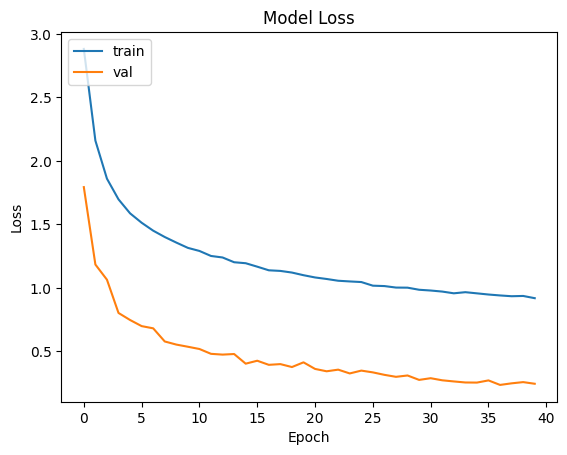

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# Save model parameters after each step
!mkdir -p /content/drive/MyDrive/models

model.save('/content/drive/MyDrive/models/COSC307_Final_CNN2.keras') # tf save format works better across configurations (the model was training in a multi-GPU environment)